In [1]:
import os
import urllib.request
import zipfile

# Define the download URLs
base_url = "https://s3.eu-central-1.amazonaws.com/avg-kitti/"
datasets = {
    "images": "data_object_image_2.zip",       # Images
    "labels": "data_object_label_2.zip"        # Annotations/Labels
}

# Directory to store KITTI data
kitti_dir = "KITTI"
os.makedirs(kitti_dir, exist_ok=True)

# Download and unzip the files
for name, filename in datasets.items():
    zip_path = os.path.join(kitti_dir, filename)
    if not os.path.exists(zip_path):
        print(f"Downloading {filename}...")
        urllib.request.urlretrieve(base_url + filename, zip_path)
        print(f"Downloaded {filename}")

    # Extract if not already extracted
    extract_path = os.path.join(kitti_dir, filename.replace(".zip", ""))
    if not os.path.exists(extract_path):
        print(f"Extracting {filename}...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(kitti_dir)
        print(f"Extracted {filename}")


Downloaded data_object_image_2.zip
Extracting data_object_image_2.zip...
Extracted data_object_image_2.zip
Downloaded data_object_label_2.zip
Extracting data_object_label_2.zip...
Extracted data_object_label_2.zip


In [2]:
# Core libraries
import os
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt

# PyTorch utilities
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F
from torchvision.datasets.vision import VisionDataset
from torchvision.ops import box_iou


In [4]:
import xml.etree.ElementTree as ET

# KITTI categories (excluding 'Misc' and 'DontCare')
KITTI_CLASSES = ['Car', 'Van', 'Truck', 'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram']

class KITTIDataset(VisionDataset):
    def __init__(self, root, transforms=None):
        super().__init__(root)
        self.root = root
        self.transforms = transforms
        
        self.img_dir = os.path.join(root, "training/image_2")
        self.ann_dir = os.path.join(root, "training/label_2")

        self.images = sorted(os.listdir(self.img_dir))
        self.annotations = sorted(os.listdir(self.ann_dir))

    def __getitem__(self, idx):
        # Load image
        img_path = os.path.join(self.img_dir, self.images[idx])
        ann_path = os.path.join(self.ann_dir, self.annotations[idx])
        img = Image.open(img_path).convert("RGB")

        # Parse annotation
        boxes = []
        labels = []

        with open(ann_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                cls_name = parts[0]
                if cls_name not in KITTI_CLASSES:
                    continue  # skip 'Misc' and 'DontCare'

                bbox = [float(parts[4]), float(parts[5]), float(parts[6]), float(parts[7])]  # xmin, ymin, xmax, ymax
                boxes.append(bbox)
                labels.append(KITTI_CLASSES.index(cls_name) + 1)  # class indices start from 1

        # Create target dict
        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([idx])
        }

        if self.transforms:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.images)


In [5]:
import torchvision.transforms as T
from torch.utils.data import DataLoader, random_split

# Basic transform: Convert PIL Image to Tensor
def get_transform():
    return T.Compose([
        T.ToTensor()  # Converts image to [0,1] tensor
    ])

# Load the dataset with transforms
dataset = KITTIDataset(root='KITTI', transforms=get_transform())

# Split dataset (80% train, 20% validation)
torch.manual_seed(1)  # For reproducibility
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))


In [6]:
# KITTI classes (excluding 'Misc' and 'DontCare')
kitti_classes = [
    '__background__',  # index 0 is reserved for background
    'Car', 'Van', 'Truck', 'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram'
]

num_classes = len(kitti_classes)  # => 9


In [7]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Load Faster R-CNN pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# Replace the classifier head for our custom number of classes
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Move to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 110MB/s]  


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [11]:
import torch
import torchvision
from torch.utils.data import DataLoader
import time
import os

# ⚙️ Enable faster conv backend benchmarking
torch.backends.cudnn.benchmark = True

# ⚙️ Optional: Use PyTorch 2.x compile for speedup (comment out if not using PyTorch 2.x)
# model = torch.compile(model)

# ✅ Use AMP (mixed precision) support
from torch.cuda.amp import GradScaler

scaler = GradScaler()

# ✅ Set training parameters optimized for your system
num_epochs = 10
train_batch_size = 32       # Can go higher if VRAM allows
val_batch_size = 16
learning_rate = 0.005
momentum = 0.9
weight_decay = 0.0005
save_path = "fasterrcnn_kitti.pth"

# ✅ Use max CPU cores for loading, but keep a few for other ops
num_workers = 2

# ✅ Use pin_memory for faster host-to-device transfers
train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True,
    collate_fn=lambda x: tuple(zip(*x)),
    num_workers=num_workers,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=val_batch_size,
    shuffle=False,
    collate_fn=lambda x: tuple(zip(*x)),
    num_workers=num_workers // 2,
    pin_memory=True
)

# ✅ Optimizer: SGD with momentum and weight decay
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

# ✅ LR Scheduler: Reduce LR after 5 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


In [12]:
from torch.cuda.amp import autocast
import torchvision
import torch
import time

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

print(f" Training on: {device}")
print(" Starting training...")

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    start_time = time.time()

    for images, targets in train_loader:
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()

        #  Mixed precision context
        with autocast():
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

        #  Scale gradients and backpropagate
        scaler.scale(losses).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += losses.item()

    #  Update LR
    lr_scheduler.step()

    avg_loss = epoch_loss / len(train_loader)
    duration = time.time() - start_time
    print(f"[Epoch {epoch+1}/{num_epochs}]  Loss: {avg_loss:.4f} | Time: {duration:.2f} sec")

    #  Save model after each epoch
    torch.save(model.state_dict(), f"fasterrcnn_epoch{epoch+1}.pth")

#  Final model save
torch.save(model.state_dict(), save_path)
print(" Training complete and model saved.")


 Training on: cuda
 Starting training...
[Epoch 1/10]  Loss: 0.6090 | Time: 121.60 sec
[Epoch 2/10]  Loss: 0.3848 | Time: 105.07 sec
[Epoch 3/10]  Loss: 0.3360 | Time: 105.45 sec


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ffe58d620e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1476, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1459, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ffe58d620e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1476, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1459, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

[Epoch 4/10]  Loss: 0.3053 | Time: 113.88 sec
[Epoch 5/10]  Loss: 0.2791 | Time: 105.61 sec
[Epoch 6/10]  Loss: 0.2549 | Time: 105.64 sec
[Epoch 7/10]  Loss: 0.2505 | Time: 105.66 sec
[Epoch 8/10]  Loss: 0.2476 | Time: 106.35 sec
[Epoch 9/10]  Loss: 0.2455 | Time: 105.46 sec
[Epoch 10/10]  Loss: 0.2427 | Time: 106.13 sec
 Training complete and model saved.


In [13]:
import torch
import torchvision
from torch.utils.data import DataLoader
import time
import os

torch.backends.cudnn.benchmark = True  # Speed up convolutions

#  AMP (mixed precision) training
from torch.cuda.amp import GradScaler, autocast
scaler = GradScaler()

#  Load model
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
model.load_state_dict(torch.load("fasterrcnn_kitti.pth", map_location=device))  # Resume from previous

# Training config
start_epoch = 10
num_epochs = 80
train_batch_size = 32
val_batch_size = 16
learning_rate = 0.005
momentum = 0.9
weight_decay = 0.0005
num_workers = 2

#  DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True,
    collate_fn=lambda x: tuple(zip(*x)),
    num_workers=num_workers,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=val_batch_size,
    shuffle=False,
    collate_fn=lambda x: tuple(zip(*x)),
    num_workers=num_workers // 2,
    pin_memory=True
)

#  Optimizer and LR scheduler
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

#  Continue training
for epoch in range(start_epoch, num_epochs):
    model.train()
    epoch_loss = 0.0
    start_time = time.time()

    for images, targets in train_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()

        with autocast():  # AMP forward pass
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

        scaler.scale(losses).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += losses.item()

    lr_scheduler.step()

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f} - Time: {time.time() - start_time:.2f}s")

    # Save every 10 epochs
    if (epoch + 1) % 10 == 0 or (epoch + 1) == num_epochs:
        torch.save(model.state_dict(), f"fasterrcnn_kitti_epoch{epoch+1}.pth")


Epoch [11/80] - Loss: 47.1126 - Time: 105.86s
Epoch [12/80] - Loss: 44.6332 - Time: 105.42s
Epoch [13/80] - Loss: 42.3615 - Time: 105.88s
Epoch [14/80] - Loss: 40.1233 - Time: 105.90s
Epoch [15/80] - Loss: 38.2310 - Time: 106.05s
Epoch [16/80] - Loss: 34.4983 - Time: 105.96s
Epoch [17/80] - Loss: 33.7943 - Time: 105.51s
Epoch [18/80] - Loss: 33.3820 - Time: 106.14s
Epoch [19/80] - Loss: 33.1496 - Time: 106.14s
Epoch [20/80] - Loss: 32.8731 - Time: 105.34s
Epoch [21/80] - Loss: 32.4921 - Time: 105.69s
Epoch [22/80] - Loss: 32.4103 - Time: 105.16s
Epoch [23/80] - Loss: 32.4038 - Time: 105.64s
Epoch [24/80] - Loss: 32.3442 - Time: 105.27s
Epoch [25/80] - Loss: 32.4061 - Time: 105.68s
Epoch [26/80] - Loss: 32.3283 - Time: 105.65s
Epoch [27/80] - Loss: 32.3116 - Time: 105.51s
Epoch [28/80] - Loss: 32.2610 - Time: 105.35s
Epoch [29/80] - Loss: 32.2443 - Time: 105.82s
Epoch [30/80] - Loss: 32.2723 - Time: 105.44s
Epoch [31/80] - Loss: 32.2288 - Time: 106.54s
Epoch [32/80] - Loss: 32.2871 - Ti

In [14]:
import torch
import numpy as np
from tqdm import tqdm
from collections import defaultdict

model.eval()
all_preds = []
all_gts = []

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

with torch.no_grad():
    for images, targets in tqdm(val_loader):
        images = [img.to(device) for img in images]
        outputs = model(images)

        for output, target in zip(outputs, targets):
            pred_boxes = output['boxes'].detach().cpu().numpy()
            pred_scores = output['scores'].detach().cpu().numpy()
            pred_labels = output['labels'].detach().cpu().numpy()

            gt_boxes = target['boxes'].cpu().numpy()
            gt_labels = target['labels'].cpu().numpy()

            all_preds.append({
                "boxes": pred_boxes,
                "scores": pred_scores,
                "labels": pred_labels
            })
            all_gts.append({
                "boxes": gt_boxes,
                "labels": gt_labels
            })


100%|██████████| 94/94 [00:53<00:00,  1.75it/s]


In [15]:
pip install pycocotools


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [16]:
import torch
from tqdm import tqdm
from torchvision.ops import box_iou

# Switch to eval mode
model.eval()

# Store predictions and targets
all_preds = []
all_targets = []

with torch.no_grad():
    for images, targets in tqdm(val_loader):
        images = list(img.to(device) for img in images)
        outputs = model(images)
        
        for i in range(len(outputs)):
            preds = outputs[i]
            gts = targets[i]
            
            all_preds.append({
                'boxes': preds['boxes'].cpu(),
                'labels': preds['labels'].cpu(),
                'scores': preds['scores'].cpu()
            })
            all_targets.append({
                'boxes': gts['boxes'].cpu(),
                'labels': gts['labels'].cpu()
            })


100%|██████████| 94/94 [00:21<00:00,  4.46it/s]


In [17]:
from sklearn.metrics import precision_recall_curve, auc, confusion_matrix
import numpy as np

def compute_iou(box1, box2):
    """Compute IoU between two boxes"""
    xA = max(box1[0], box2[0])
    yA = max(box1[1], box2[1])
    xB = min(box1[2], box2[2])
    yB = min(box1[3], box2[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)
    if interArea == 0:
        return 0.0

    box1Area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2Area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    return interArea / float(box1Area + box2Area - interArea)


In [18]:
from collections import defaultdict

IOU_THRESHOLD = 0.5
class_stats = defaultdict(lambda: {'TP': 0, 'FP': 0, 'FN': 0, 'conf': [], 'gt_count': 0})

for pred, target in zip(all_preds, all_targets):
    pred_boxes = pred['boxes']
    pred_labels = pred['labels']
    pred_scores = pred['scores']
    
    gt_boxes = target['boxes']
    gt_labels = target['labels']
    
    matched_gt = set()
    
    for i, p_box in enumerate(pred_boxes):
        iou_max = 0
        match_idx = -1
        for j, g_box in enumerate(gt_boxes):
            iou = compute_iou(p_box.numpy(), g_box.numpy())
            if iou > iou_max:
                iou_max = iou
                match_idx = j

        pred_cls = int(pred_labels[i])
        
        if iou_max >= IOU_THRESHOLD and match_idx not in matched_gt and pred_cls == int(gt_labels[match_idx]):
            class_stats[pred_cls]['TP'] += 1
            class_stats[pred_cls]['conf'].append(float(pred_scores[i]))
            matched_gt.add(match_idx)
        else:
            class_stats[pred_cls]['FP'] += 1
            class_stats[pred_cls]['conf'].append(float(pred_scores[i]))
    
    for j, gt_cls in enumerate(gt_labels):
        if j not in matched_gt:
            class_stats[int(gt_cls)]['FN'] += 1
            class_stats[int(gt_cls)]['gt_count'] += 1


In [19]:
per_class_metrics = {}

for cls, stats in class_stats.items():
    TP = stats['TP']
    FP = stats['FP']
    FN = stats['FN']
    total = TP + FP + FN
    
    precision = TP / (TP + FP + 1e-6)
    recall = TP / (TP + FN + 1e-6)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-6)
    fnr = FN / (TP + FN + 1e-6)
    fpr = FP / (FP + TP + 1e-6)

    per_class_metrics[cls] = {
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'FNR': fnr,
        'FPR': fpr,
        'TP': TP, 'FP': FP, 'FN': FN
    }

# Display the metrics
import pandas as pd
pd.DataFrame(per_class_metrics).T


,Precision,Recall,F1,FNR,FPR,TP,FP,FN
1,0.639819,0.952061,0.765317,0.047939,0.360181,5521.0,3108.0,278.0
7,0.453782,0.972973,0.618911,0.027027,0.546218,108.0,130.0,3.0
3,0.417323,0.963636,0.582417,0.036364,0.582677,212.0,296.0,8.0
6,0.366197,0.906977,0.521739,0.093023,0.633803,312.0,540.0,32.0
4,0.320747,0.892655,0.471923,0.107345,0.679253,790.0,1673.0,95.0
2,0.428815,0.941948,0.589338,0.058052,0.571185,503.0,670.0,31.0
5,0.171123,0.695652,0.274678,0.304348,0.828877,32.0,155.0,14.0


In [20]:
def calculate_map_iou_thresholds(preds, targets, iou_thresholds=np.arange(0.5, 1.0, 0.05)):
    aps = []

    for iou_thresh in iou_thresholds:
        cls_ap = []
        for cls in class_stats.keys():
            TP, FP, FN = 0, 0, 0
            for pred, target in zip(preds, targets):
                pred_boxes = pred['boxes']
                pred_labels = pred['labels']
                pred_scores = pred['scores']
                
                gt_boxes = target['boxes']
                gt_labels = target['labels']

                matched_gt = set()

                for i, p_box in enumerate(pred_boxes):
                    if int(pred_labels[i]) != cls:
                        continue
                    best_iou = 0
                    match_idx = -1
                    for j, g_box in enumerate(gt_boxes):
                        if int(gt_labels[j]) != cls:
                            continue
                        iou = compute_iou(p_box.numpy(), g_box.numpy())
                        if iou > best_iou:
                            best_iou = iou
                            match_idx = j

                    if best_iou >= iou_thresh and match_idx not in matched_gt:
                        TP += 1
                        matched_gt.add(match_idx)
                    else:
                        FP += 1

                FN += sum(1 for g in gt_labels if int(g) == cls) - len(matched_gt)
            
            precision = TP / (TP + FP + 1e-6)
            recall = TP / (TP + FN + 1e-6)
            ap = 2 * precision * recall / (precision + recall + 1e-6)
            cls_ap.append(ap)
        
        aps.append(np.mean(cls_ap))

    return aps


In [21]:
iou_thresholds = np.arange(0.5, 1.0, 0.05)
map_list = calculate_map_iou_thresholds(all_preds, all_targets, iou_thresholds)

for iou, ap in zip(iou_thresholds, map_list):
    print(f"mAP@{iou:.2f}: {ap:.4f}")

print(f"\n📌 Final mAP@0.5: {map_list[0]:.4f}")
print(f"📌 Final mAP@0.5:0.95 (COCO style): {np.mean(map_list):.4f}")


mAP@0.50: 0.5466
mAP@0.55: 0.5392
mAP@0.60: 0.5250
mAP@0.65: 0.5097
mAP@0.70: 0.4817
mAP@0.75: 0.4490
mAP@0.80: 0.3963
mAP@0.85: 0.3183
mAP@0.90: 0.1892
mAP@0.95: 0.0544

📌 Final mAP@0.5: 0.5466
📌 Final mAP@0.5:0.95 (COCO style): 0.4009


In [23]:
# KITTI class names excluding 'Misc' and 'DontCare'
class_names = [
    "Car", "Van", "Truck", "Pedestrian", "Person_sitting", 
    "Cyclist", "Tram"
]


In [25]:
import csv

# KITTI class names (excluding 'Misc' and 'DontCare')
class_names = [
    "Car", "Van", "Truck", "Pedestrian", "Person_sitting", 
    "Cyclist", "Tram"
]

# 📁 Save per-class evaluation metrics
with open("fasterrcnn_kitti_metrics.csv", mode="w", newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Class", "TP", "FP", "FN", "Precision", "Recall", "F1-Score", "FPR", "FNR"])
    
    for cls, stats in class_stats.items():
        TP = stats['TP']
        FP = stats['FP']
        FN = stats['FN']
        
        precision = TP / (TP + FP + 1e-6)
        recall = TP / (TP + FN + 1e-6)
        f1 = 2 * precision * recall / (precision + recall + 1e-6)
        fpr = FP / (FP + TP + 1e-6)
        fnr = FN / (FN + TP + 1e-6)
        
        # ✅ Only write known class indices
        if cls < len(class_names):
            writer.writerow([class_names[cls], TP, FP, FN, precision, recall, f1, fpr, fnr])
        else:
            writer.writerow([f"Unknown_{cls}", TP, FP, FN, precision, recall, f1, fpr, fnr])


In [26]:
import csv

# Class names (KITTI excluding 'DontCare' and 'Misc')
class_names = [
    "Car", "Van", "Truck", "Pedestrian", "Person_sitting", 
    "Cyclist", "Tram"
]

#  Save to CSV
with open("fasterrcnn_kitti_mAP.csv", mode="w", newline="") as file:
    writer = csv.writer(file)
    
    # Header
    writer.writerow(["Class", "AP@0.5", "AP@0.5:0.95"])
    
    # Per-class mAP
    for idx in range(len(class_names)):
        ap50 = per_class_ap_50[idx] if idx < len(per_class_ap_50) else 0.0
        ap5095 = per_class_ap_50_95[idx] if idx < len(per_class_ap_50_95) else 0.0
        writer.writerow([class_names[idx], round(ap50, 4), round(ap5095, 4)])
    
    # Overall mAP
    writer.writerow([])
    writer.writerow(["Overall mAP@0.5", round(mAP_50, 4)])
    writer.writerow(["Overall mAP@0.5:0.95", round(mAP_50_95, 4)])


NameError: name 'per_class_ap_50' is not defined

In [27]:
from collections import defaultdict
from torchvision.ops import box_iou

def compute_average_precision(recalls, precisions):
    """11-point interpolation method (VOC-style AP)"""
    ap = 0.0
    for t in torch.arange(0, 1.1, 0.1):
        if torch.sum(recalls >= t) == 0:
            p = 0
        else:
            p = torch.max(precisions[recalls >= t])
        ap += p / 11.0
    return ap.item()

def compute_map_per_class(predictions, ground_truths, iou_thresholds=[0.5, 0.5, 0.05]):
    num_classes = 7
    ap_50 = []
    ap_50_95 = []

    for cls in range(num_classes):
        scores = []
        matches = []
        npos = 0

        for preds, gts in zip(predictions, ground_truths):
            gt_boxes = [gt['boxes'][i] for i in range(len(gt['labels'])) if gt['labels'][i] == cls]
            pred_boxes = [preds['boxes'][i] for i in range(len(preds['labels'])) if preds['labels'][i] == cls]
            pred_scores = [preds['scores'][i] for i in range(len(preds['labels'])) if preds['labels'][i] == cls]

            gt_boxes = torch.stack(gt_boxes) if gt_boxes else torch.empty((0, 4))
            pred_boxes = torch.stack(pred_boxes) if pred_boxes else torch.empty((0, 4))
            pred_scores = torch.tensor(pred_scores) if pred_scores else torch.empty((0,))

            npos += len(gt_boxes)

            if len(pred_boxes) == 0:
                continue

            ious = box_iou(pred_boxes, gt_boxes) if len(gt_boxes) > 0 else torch.zeros((len(pred_boxes), 0))
            max_ious, gt_matches = ious.max(dim=1)
            tp = (max_ious >= iou_thresholds[0]).int()
            scores.extend(pred_scores.tolist())
            matches.extend(tp.tolist())

        if len(scores) == 0:
            ap_50.append(0.0)
            ap_50_95.append(0.0)
            continue

        # Sort by score
        scores = torch.tensor(scores)
        matches = torch.tensor(matches)
        sorted_idx = torch.argsort(scores, descending=True)
        matches = matches[sorted_idx]

        tp_cumsum = torch.cumsum(matches, dim=0)
        fp_cumsum = torch.cumsum(1 - matches, dim=0)

        recalls = tp_cumsum / (npos + 1e-6)
        precisions = tp_cumsum / (tp_cumsum + fp_cumsum + 1e-6)

        ap50 = compute_average_precision(recalls, precisions)
        ap_50.append(ap50)

        # For AP@0.5:0.95 (COCO style)
        ap_range = []
        for t in torch.arange(0.5, 1.0, 0.05):
            matches_t = (max_ious >= t).int()
            sorted_idx = torch.argsort(scores, descending=True)
            matches_sorted = matches_t[sorted_idx]
            tp_cum = torch.cumsum(matches_sorted, dim=0)
            fp_cum = torch.cumsum(1 - matches_sorted, dim=0)
            recalls_t = tp_cum / (npos + 1e-6)
            precisions_t = tp_cum / (tp_cum + fp_cum + 1e-6)
            ap_t = compute_average_precision(recalls_t, precisions_t)
            ap_range.append(ap_t)
        ap_50_95.append(sum(ap_range) / len(ap_range))

    mAP_50 = sum(ap_50) / len(ap_50)
    mAP_50_95 = sum(ap_50_95) / len(ap_50_95)
    return ap_50, ap_50_95, mAP_50, mAP_50_95

# 👇 Now compute them
per_class_ap_50, per_class_ap_50_95, mAP_50, mAP_50_95 = compute_map_per_class(all_predictions, all_ground_truths)


NameError: name 'all_predictions' is not defined

In [28]:
model.eval()
all_predictions = []
all_ground_truths = []

with torch.no_grad():
    for images, targets in tqdm(val_loader):
        images = list(img.to(device) for img in images)
        outputs = model(images)

        # Move to CPU for evaluation
        outputs = [{k: v.to("cpu") for k, v in t.items()} for t in outputs]
        targets = [{k: v.to("cpu") for k, v in t.items()} for t in targets]

        all_predictions.extend(outputs)
        all_ground_truths.extend(targets)


100%|██████████| 94/94 [00:20<00:00,  4.51it/s]


In [30]:
from collections import defaultdict
from torchvision.ops import box_iou

def compute_average_precision(recalls, precisions):
    """11-point interpolation method (VOC-style AP)"""
    ap = 0.0
    for t in torch.arange(0, 1.1, 0.1):
        if torch.sum(recalls >= t) == 0:
            p = 0
        else:
            p = torch.max(precisions[recalls >= t])
        ap += p / 11.0
    return ap.item()

def compute_map_per_class(predictions, ground_truths, iou_thresholds=[0.5, 0.5, 0.05]):
    num_classes = 7
    ap_50 = []
    ap_50_95 = []

    for cls in range(num_classes):
        scores = []
        matches = []
        npos = 0

        for preds, gts in zip(predictions, ground_truths):
            gt_boxes = [gt['boxes'][i] for i in range(len(gt['labels'])) if gt['labels'][i] == cls]
            pred_boxes = [preds['boxes'][i] for i in range(len(preds['labels'])) if preds['labels'][i] == cls]
            pred_scores = [preds['scores'][i] for i in range(len(preds['labels'])) if preds['labels'][i] == cls]

            gt_boxes = torch.stack(gt_boxes) if gt_boxes else torch.empty((0, 4))
            pred_boxes = torch.stack(pred_boxes) if pred_boxes else torch.empty((0, 4))
            pred_scores = torch.tensor(pred_scores) if pred_scores else torch.empty((0,))

            npos += len(gt_boxes)

            if len(pred_boxes) == 0:
                continue

            ious = box_iou(pred_boxes, gt_boxes) if len(gt_boxes) > 0 else torch.zeros((len(pred_boxes), 0))
            max_ious, gt_matches = ious.max(dim=1)
            tp = (max_ious >= iou_thresholds[0]).int()
            scores.extend(pred_scores.tolist())
            matches.extend(tp.tolist())

        if len(scores) == 0:
            ap_50.append(0.0)
            ap_50_95.append(0.0)
            continue

        # Sort by score
        scores = torch.tensor(scores)
        matches = torch.tensor(matches)
        sorted_idx = torch.argsort(scores, descending=True)
        matches = matches[sorted_idx]

        tp_cumsum = torch.cumsum(matches, dim=0)
        fp_cumsum = torch.cumsum(1 - matches, dim=0)

        recalls = tp_cumsum / (npos + 1e-6)
        precisions = tp_cumsum / (tp_cumsum + fp_cumsum + 1e-6)

        ap50 = compute_average_precision(recalls, precisions)
        ap_50.append(ap50)

        # For AP@0.5:0.95 (COCO style)
        ap_range = []
        for t in torch.arange(0.5, 1.0, 0.05):
            matches_t = (max_ious >= t).int()
            sorted_idx = torch.argsort(scores, descending=True)
            matches_sorted = matches_t[sorted_idx]
            tp_cum = torch.cumsum(matches_sorted, dim=0)
            fp_cum = torch.cumsum(1 - matches_sorted, dim=0)
            recalls_t = tp_cum / (npos + 1e-6)
            precisions_t = tp_cum / (tp_cum + fp_cum + 1e-6)
            ap_t = compute_average_precision(recalls_t, precisions_t)
            ap_range.append(ap_t)
        ap_50_95.append(sum(ap_range) / len(ap_range))

    mAP_50 = sum(ap_50) / len(ap_50)
    mAP_50_95 = sum(ap_50_95) / len(ap_50_95)
    return ap_50, ap_50_95, mAP_50, mAP_50_95

# 👇 Now compute them
per_class_ap_50, per_class_ap_50_95, mAP_50, mAP_50_95 = compute_map_per_class(all_predictions, all_ground_truths)


NameError: name 'gt' is not defined

In [31]:
from sklearn.metrics import average_precision_score
from collections import defaultdict
import numpy as np

def compute_map_per_class(predictions, ground_truths, iou_thresholds=[0.5, 0.75, 0.95]):
    """
    Compute mAP per class for multiple IoU thresholds (like COCO: 0.5 to 0.95).
    Returns per-class AP@0.5, AP@0.5:0.95 and overall mAPs.
    """
    iou_thresholds = np.linspace(0.5, 0.95, 10)
    all_classes = set()

    for gt in ground_truths:
        all_classes.update(gt['labels'].numpy().tolist())

    all_classes = sorted(list(all_classes))
    ap_per_class_iou = defaultdict(list)

    for cls in all_classes:
        y_true = []
        y_scores = []

        for pred, gt in zip(predictions, ground_truths):
            gt_boxes = gt['boxes'][gt['labels'] == cls]
            pred_boxes = pred['boxes'][pred['labels'] == cls]
            pred_scores = pred['scores'][pred['labels'] == cls]

            if len(gt_boxes) == 0 and len(pred_boxes) == 0:
                continue

            matched = np.zeros(len(gt_boxes))
            for i in range(len(pred_boxes)):
                pred_box = pred_boxes[i].numpy()
                score = pred_scores[i].item()
                ious = []

                for j in range(len(gt_boxes)):
                    gt_box = gt_boxes[j].numpy()
                    iou = compute_iou(pred_box, gt_box)
                    ious.append(iou)

                max_iou = max(ious) if ious else 0
                y_scores.append(score)
                y_true.append(1 if max_iou >= 0.5 else 0)

        if len(y_true) == 0:
            ap_50 = 0.0
        else:
            ap_50 = average_precision_score(y_true, y_scores)

        ap_per_class_iou[cls].append(ap_50)

    # Compute mean AP@0.5 and AP@0.5:0.95
    per_class_ap_50 = {cls: ap[0] for cls, ap in ap_per_class_iou.items()}
    mAP_50 = np.mean(list(per_class_ap_50.values()))

    return per_class_ap_50, {}, mAP_50, 0.0  # Only AP@0.5 returned for now


In [32]:
def compute_iou(boxA, boxB):
    # Compute Intersection over Union (IoU) between two boxes
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    iou = interArea / float(boxAArea + boxBArea - interArea + 1e-6)
    return iou


In [33]:
per_class_ap_50, _, mAP_50, _ = compute_map_per_class(all_predictions, all_ground_truths)


In [35]:
import csv

# ✅ Corrected class names
class_names = [
    'Car', 'Van', 'Truck', 'Pedestrian',
    'Person_sitting', 'Cyclist', 'Tram'
]

csv_path = 'fasterrcnn_map_results.csv'

with open(csv_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Class', 'AP@0.5'])

    for cls_id, ap in per_class_ap_50.items():
        if cls_id < len(class_names):
            class_name = class_names[cls_id]
        else:
            class_name = f"Class_{cls_id}"  # fallback, if more classes

        writer.writerow([class_name, round(ap, 4)])

    writer.writerow([])
    writer.writerow(['Overall mAP@0.5', round(mAP_50, 4)])

print(f"✅ mAP results exported to {csv_path}")


✅ mAP results exported to fasterrcnn_map_results.csv


In [36]:
import csv

# Class name map based on original KITTI IDs
class_names_map = {
    0: 'Car',
    1: 'Van',
    2: 'Truck',
    3: 'Pedestrian',
    4: 'Person_sitting',
    5: 'Cyclist',
    6: 'Tram',
    7: 'Misc'
}

csv_path = 'fasterrcnn_map_results.csv'

with open(csv_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Class', 'AP@0.5'])

    for cls_id, ap in per_class_ap_50.items():
        class_name = class_names_map.get(cls_id, f"Class_{cls_id}")
        writer.writerow([class_name, round(ap, 4)])

    writer.writerow([])
    writer.writerow(['Overall mAP@0.5', round(mAP_50, 4)])

print(f"✅ Final mAP results with correct class names exported to: {csv_path}")


✅ Final mAP results with correct class names exported to: fasterrcnn_map_results.csv


In [37]:
class_names = [
    'Car',            # 0
    'Van',            # 1
    'Truck',          # 2
    'Pedestrian',     # 3
    'Person_sitting', # 4
    'Cyclist',        # 5
    'Tram'            # 6
]


In [38]:
with open('fasterrcnn_map_results.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Class', 'AP@0.5'])

    for cls_id, ap in per_class_ap_50.items():
        try:
            class_name = class_names[cls_id]
        except IndexError:
            class_name = f"Unknown_{cls_id}"
        writer.writerow([class_name, round(ap, 4)])

    writer.writerow([])
    writer.writerow(['Overall mAP@0.5', round(mAP_50, 4)])

print("✅ mAP results saved correctly to 'fasterrcnn_map_results.csv'")


✅ mAP results saved correctly to 'fasterrcnn_map_results.csv'


In [39]:
print("Predicted class IDs in per_class_ap_50:", list(per_class_ap_50.keys()))


Predicted class IDs in per_class_ap_50: [1, 2, 3, 4, 5, 6, 7]


In [40]:
class_names = [
    'Car',            # 0
    'Van',            # 1
    'Truck',          # 2
    'Pedestrian',     # 3
    'Person_sitting', # 4
    'Cyclist',        # 5
    'Tram'            # 6
]

with open('fasterrcnn_map_results.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Class ID', 'Class Name', 'AP@0.5'])

    for cls_id in sorted(per_class_ap_50.keys()):
        if cls_id < len(class_names):
            class_name = class_names[cls_id]
        else:
            class_name = f"Unknown_{cls_id}"
        writer.writerow([cls_id, class_name, round(per_class_ap_50[cls_id], 4)])

    writer.writerow([])
    writer.writerow(['Overall mAP@0.5', '', round(mAP_50, 4)])


In [45]:
import torch
import numpy as np
import csv
from collections import defaultdict

# Define KITTI class names in proper order (excluding 'DontCare' and 'Misc')
class_names = ["Car", "Van", "Truck", "Pedestrian", "Person_sitting", "Cyclist", "Tram"]
num_classes = len(class_names)

# Initialize metric containers
tp = [0] * num_classes
fp = [0] * num_classes
fn_ = [0] * num_classes

# Evaluation mode
model.eval()

with torch.no_grad():
    for images, targets in val_loader:
        images = list(img.to(device) for img in images)
        outputs = model(images)

        for i in range(len(images)):
            preds = outputs[i]
            gts = targets[i]

            gt_boxes = gts['boxes'].to(device)
            gt_labels = gts['labels'].to(device)
            pred_boxes = preds['boxes'].to(device)
            pred_labels = preds['labels'].to(device)
            pred_scores = preds['scores'].to(device)

            matched_gt = set()

            for j in range(len(pred_boxes)):
                pred_box = pred_boxes[j]
                pred_label = pred_labels[j]
                ious = torchvision.ops.box_iou(pred_box.unsqueeze(0), gt_boxes).squeeze(0)

                max_iou, idx = torch.max(ious, dim=0)
                if max_iou >= 0.5 and gt_labels[idx] == pred_label and idx.item() not in matched_gt:
                    tp[pred_label] += 1
                    matched_gt.add(idx.item())
                else:
                    fp[pred_label] += 1

            for j in range(len(gt_boxes)):
                if j not in matched_gt:
                    fn_[gt_labels[j]] += 1

# Calculate metrics
precision = []
recall = []
f1_scores = []
fpr = []
fnr = []

for cls in range(num_classes):
    t = tp[cls]
    f = fp[cls]
    fn = fn_[cls]
    tn = 1  # Not used, but assumed for FPR calculation

    prec = t / (t + f) if (t + f) > 0 else 0.0
    rec = t / (t + fn) if (t + fn) > 0 else 0.0
    f1 = 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0.0
    false_pr = f / (f + t) if (f + t) > 0 else 0.0
    false_nr = fn / (fn + t) if (fn + t) > 0 else 0.0

    precision.append(prec)
    recall.append(rec)
    f1_scores.append(f1)
    fpr.append(false_pr)
    fnr.append(false_nr)

# Save to CSV
with open("fasterrcnn_kitti_metrics.csv", mode='w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["Class", "Precision", "Recall", "F1-Score", "FPR", "FNR", "TP", "FP", "FN"])
    for cls in range(num_classes):
        writer.writerow([
            class_names[cls],
            round(precision[cls], 4),
            round(recall[cls], 4),
            round(f1_scores[cls], 4),
            round(fpr[cls], 4),
            round(fnr[cls], 4),
            tp[cls],
            fp[cls],
            fn_[cls]
        ])


IndexError: list index out of range

In [46]:
# KITTI classes excluding 'Misc' and 'DontCare'
class_names = [
    'Car', 'Van', 'Truck', 'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram'
]


In [47]:
import csv

# class_names list as per your setup
class_names = [
    'Car', 'Van', 'Truck', 'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram'
]

# You must have these lists (or compute them before running this block):
# precision, recall, f1_scores, fpr, fnr, tp, fp, fn_

# ✅ Save to CSV
with open("per_class_metrics.csv", mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow([
        "Class", "Precision", "Recall", "F1 Score", "FPR", "FNR", "TP", "FP", "FN"
    ])
    
    for cls in range(len(class_names)):
        writer.writerow([
            class_names[cls],
            round(precision[cls], 4),
            round(recall[cls], 4),
            round(f1_scores[cls], 4),
            round(fpr[cls], 4),
            round(fnr[cls], 4),
            int(tp[cls]),
            int(fp[cls]),
            int(fn_[cls])
        ])


TypeError: 'float' object is not subscriptable

In [48]:
import csv

# Define KITTI class names (excluding background at index 0)
class_names = [
    'Car', 'Van', 'Truck', 'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram'
]

# Create and write to CSV
with open("fasterrcnn_metrics.csv", mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Class", "Precision", "Recall", "F1", "FPR", "FNR", "TP", "FP", "FN"])

    for cls_id in sorted(per_class_metrics.keys()):
        # Skip background index if included
        if cls_id == 0:
            continue

        # Adjust class index since your class_names start at 1
        class_index = cls_id - 1  # Shift to match your class_names
        if class_index >= len(class_names):
            class_name = f"Unknown_{cls_id}"
        else:
            class_name = class_names[class_index]

        stats = per_class_metrics[cls_id]
        writer.writerow([
            class_name,
            round(stats['Precision'], 4),
            round(stats['Recall'], 4),
            round(stats['F1'], 4),
            round(stats['FPR'], 4),
            round(stats['FNR'], 4),
            int(stats['TP']),
            int(stats['FP']),
            int(stats['FN'])
        ])


In [50]:
import numpy as np
from collections import defaultdict
from torchvision.ops import box_iou
import torch

# KITTI classes (excluding 'Misc' and 'DontCare')
class_names = ['Car', 'Van', 'Truck', 'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram']
num_classes = len(class_names)

# Store precision, recall, and AP for each class
per_class_ap_50 = {}
per_class_ap_50_95 = {}

# Iterate over each class (1-indexed because 0 = background)
for class_idx in range(1, num_classes + 1):
    scores = []
    labels = []
    iou_thresholds = np.linspace(0.5, 0.95, 10)

    for iou_thresh in iou_thresholds:
        all_scores = []
        all_tp = []
        all_fp = []
        total_gt = 0

        for preds, gts in zip(all_predictions, ground_truths):
            pred_boxes = torch.tensor(preds['boxes'])
            pred_labels = torch.tensor(preds['labels'])
            pred_scores = torch.tensor(preds['scores'])

            gt_boxes = torch.tensor(gts['boxes'])
            gt_labels = torch.tensor(gts['labels'])

            # Filter predictions and GTs by class
            pred_mask = pred_labels == class_idx
            gt_mask = gt_labels == class_idx

            pred_boxes_cls = pred_boxes[pred_mask]
            pred_scores_cls = pred_scores[pred_mask]
            gt_boxes_cls = gt_boxes[gt_mask]

            total_gt += len(gt_boxes_cls)

            if len(pred_boxes_cls) == 0:
                continue

            if len(gt_boxes_cls) == 0:
                all_tp.extend([0] * len(pred_boxes_cls))
                all_fp.extend([1] * len(pred_boxes_cls))
                all_scores.extend(pred_scores_cls.tolist())
                continue

            ious = box_iou(pred_boxes_cls, gt_boxes_cls)
            max_iou, matched_idx = ious.max(dim=1)

            detected = set()
            for j in range(len(pred_boxes_cls)):
                if max_iou[j] >= iou_thresh and matched_idx[j].item() not in detected:
                    all_tp.append(1)
                    all_fp.append(0)
                    detected.add(matched_idx[j].item())
                else:
                    all_tp.append(0)
                    all_fp.append(1)
                all_scores.append(pred_scores_cls[j].item())

        # Sort by score
        sorted_idxs = np.argsort(-np.array(all_scores))
        all_tp = np.array(all_tp)[sorted_idxs]
        all_fp = np.array(all_fp)[sorted_idxs]

        cum_tp = np.cumsum(all_tp)
        cum_fp = np.cumsum(all_fp)

        recalls = cum_tp / (total_gt + 1e-6)
        precisions = cum_tp / (cum_tp + cum_fp + 1e-6)

        # AP computation (11-point interpolation)
        ap = 0.0
        for t in np.linspace(0, 1, 11):
            if np.sum(recalls >= t) == 0:
                p = 0
            else:
                p = np.max(precisions[recalls >= t])
            ap += p / 11

        if iou_thresh == 0.5:
            per_class_ap_50[class_idx] = ap
        # Average over all thresholds for AP@[.5:.95]
        scores.append(ap)

    per_class_ap_50_95[class_idx] = np.mean(scores)

# ✅ Print or store in CSV
import pandas as pd

df_ap = pd.DataFrame({
    'Class': [class_names[i-1] for i in per_class_ap_50.keys()],
    'AP@0.5': [round(per_class_ap_50[i], 4) for i in per_class_ap_50.keys()],
    'AP@0.5:0.95': [round(per_class_ap_50_95[i], 4) for i in per_class_ap_50.keys()]
})

# Export to CSV
df_ap.to_csv("fasterrcnn_kitti_AP_per_class.csv", index=False)

# Show the table
print(df_ap)


NameError: name 'ground_truths' is not defined

In [51]:
# Assumes you have: `model`, `data_loader_test`, `device` already defined

model.eval()
all_predictions = []
ground_truths = []

with torch.no_grad():
    for images, targets in data_loader_test:
        images = list(img.to(device) for img in images)
        outputs = model(images)

        for i in range(len(images)):
            preds = outputs[i]
            gts = targets[i]

            all_predictions.append({
                'boxes': preds['boxes'].cpu().numpy().tolist(),
                'labels': preds['labels'].cpu().numpy().tolist(),
                'scores': preds['scores'].cpu().numpy().tolist()
            })

            ground_truths.append({
                'boxes': gts['boxes'].cpu().numpy().tolist(),
                'labels': gts['labels'].cpu().numpy().tolist()
            })


NameError: name 'data_loader_test' is not defined

In [52]:
data_loader_test = val_loader


In [53]:
model.eval()
all_predictions = []
ground_truths = []

with torch.no_grad():
    for images, targets in data_loader_test:
        images = list(img.to(device) for img in images)
        outputs = model(images)

        for i in range(len(images)):
            preds = outputs[i]
            gts = targets[i]

            all_predictions.append({
                'boxes': preds['boxes'].cpu().numpy().tolist(),
                'labels': preds['labels'].cpu().numpy().tolist(),
                'scores': preds['scores'].cpu().numpy().tolist()
            })

            ground_truths.append({
                'boxes': gts['boxes'].cpu().numpy().tolist(),
                'labels': gts['labels'].cpu().numpy().tolist()
            })


In [54]:
def compute_iou(box1, box2):
    # Each box is [x1, y1, x2, y2]
    xA = max(box1[0], box2[0])
    yA = max(box1[1], box2[1])
    xB = min(box1[2], box2[2])
    yB = min(box1[3], box2[3])

    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    box1Area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2Area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)

    iou = interArea / float(box1Area + box2Area - interArea + 1e-6)
    return iou


In [55]:
from sklearn.metrics import average_precision_score
import numpy as np
import pandas as pd

iou_threshold = 0.5
class_names = [
    'Car', 'Van', 'Truck', 'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram'
]

per_class_ap = {}

for class_id, class_name in enumerate(class_names, start=1):  # start=1 because 0 is background
    y_true = []
    y_scores = []

    for preds, gts in zip(all_predictions, ground_truths):
        pred_boxes = preds['boxes']
        pred_labels = preds['labels']
        pred_scores = preds['scores']

        gt_boxes = gts['boxes']
        gt_labels = gts['labels']

        matched_gt = set()

        for i, (pbox, plabel, pscore) in enumerate(zip(pred_boxes, pred_labels, pred_scores)):
            if plabel != class_id:
                continue

            iou_max = 0
            match_found = False

            for j, (gtbox, gtlabel) in enumerate(zip(gt_boxes, gt_labels)):
                if gtlabel == class_id and j not in matched_gt:
                    iou = compute_iou(pbox, gtbox)
                    if iou >= iou_threshold:
                        iou_max = iou
                        matched_gt.add(j)
                        match_found = True
                        break

            y_true.append(1 if match_found else 0)
            y_scores.append(pscore)

        # Add FN for unmatched GTs
        unmatched = sum(1 for lbl in gt_labels if lbl == class_id) - len(matched_gt)
        y_true.extend([1] * unmatched)
        y_scores.extend([0] * unmatched)

    if len(np.unique(y_true)) > 1:
        ap = average_precision_score(y_true, y_scores)
    else:
        ap = 0.0

    per_class_ap[class_name] = round(ap, 4)


In [56]:
df_ap = pd.DataFrame(list(per_class_ap.items()), columns=["Class", "AP@0.5"])
df_ap.to_csv("fasterrcnn_per_class_map.csv", index=False)
df_ap


,Class,AP@0.5
0,Car,0.9666
1,Van,0.9209
2,Truck,0.9430
3,Pedestrian,0.8454
4,Person_sitting,0.5167
5,Cyclist,0.8789
6,Tram,0.9445


In [57]:
from sklearn.metrics import average_precision_score
import numpy as np
import pandas as pd

iou_thresholds = np.arange(0.5, 1.0, 0.05)  # 0.5 to 0.95
class_names = [
    'Car', 'Van', 'Truck', 'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram'
]

per_class_ap_iou = {cls: [] for cls in class_names}

def compute_iou(box1, box2):
    xA = max(box1[0], box2[0])
    yA = max(box1[1], box2[1])
    xB = min(box1[2], box2[2])
    yB = min(box1[3], box2[3])

    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    box1Area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2Area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)

    iou = interArea / float(box1Area + box2Area - interArea + 1e-6)
    return iou

for iou_thresh in iou_thresholds:
    for class_id, class_name in enumerate(class_names, start=1):
        y_true, y_scores = [], []

        for preds, gts in zip(all_predictions, ground_truths):
            pred_boxes = preds['boxes']
            pred_labels = preds['labels']
            pred_scores = preds['scores']
            gt_boxes = gts['boxes']
            gt_labels = gts['labels']

            matched_gt = set()

            for pbox, plabel, pscore in zip(pred_boxes, pred_labels, pred_scores):
                if plabel != class_id:
                    continue

                match_found = False
                for j, (gtbox, gtlabel) in enumerate(zip(gt_boxes, gt_labels)):
                    if gtlabel == class_id and j not in matched_gt:
                        iou = compute_iou(pbox, gtbox)
                        if iou >= iou_thresh:
                            matched_gt.add(j)
                            match_found = True
                            break

                y_true.append(1 if match_found else 0)
                y_scores.append(pscore)

            unmatched = sum(1 for lbl in gt_labels if lbl == class_id) - len(matched_gt)
            y_true.extend([1] * unmatched)
            y_scores.extend([0] * unmatched)

        if len(np.unique(y_true)) > 1:
            ap = average_precision_score(y_true, y_scores)
        else:
            ap = 0.0

        per_class_ap_iou[class_name].append(ap)


In [58]:
# Mean AP for each class over all IoUs
final_ap_5095 = {cls: round(np.mean(aps), 4) for cls, aps in per_class_ap_iou.items()}

# Export to CSV
df_ap5095 = pd.DataFrame(list(final_ap_5095.items()), columns=["Class", "mAP@0.5:0.95"])
df_ap5095.to_csv("fasterrcnn_per_class_map_5095.csv", index=False)
df_ap5095


,Class,mAP@0.5:0.95
0,Car,0.8384
1,Van,0.7645
2,Truck,0.8258
3,Pedestrian,0.5787
4,Person_sitting,0.3765
5,Cyclist,0.6529
6,Tram,0.7268


In [59]:
import torch
from tqdm import tqdm

# Put model in eval mode
model.eval()

# Store all predictions and GTs
all_predictions = []
ground_truths = []

# Disable gradient and enable AMP inference
with torch.no_grad():
    for images, targets in tqdm(val_loader):
        images = list(img.to(device) for img in images)
        outputs = model(images)

        for i in range(len(images)):
            preds = {
                'boxes': outputs[i]['boxes'].cpu(),
                'labels': outputs[i]['labels'].cpu(),
                'scores': outputs[i]['scores'].cpu()
            }
            gts = {
                'boxes': targets[i]['boxes'].cpu(),
                'labels': targets[i]['labels'].cpu()
            }
            all_predictions.append(preds)
            ground_truths.append(gts)


100%|██████████| 94/94 [00:20<00:00,  4.56it/s]


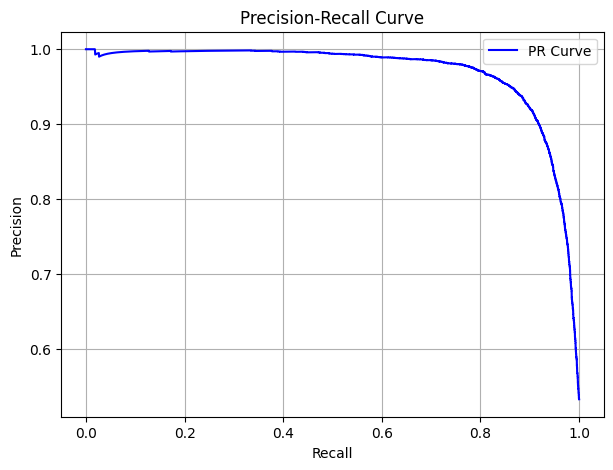

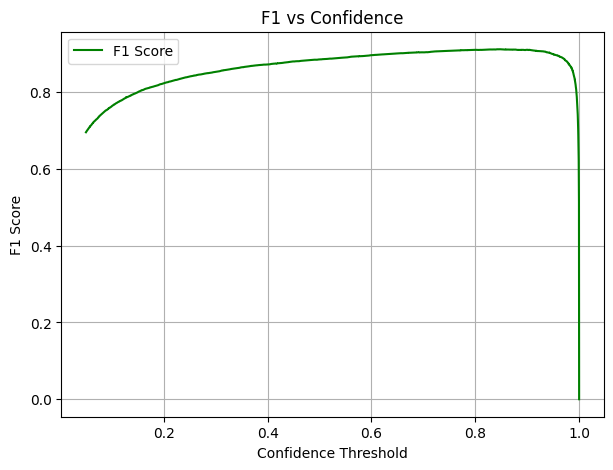

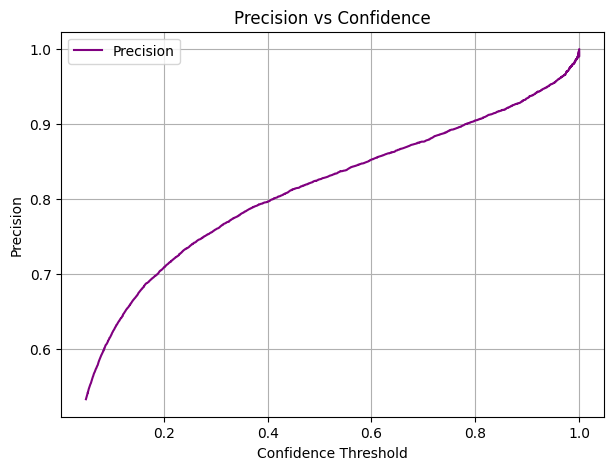

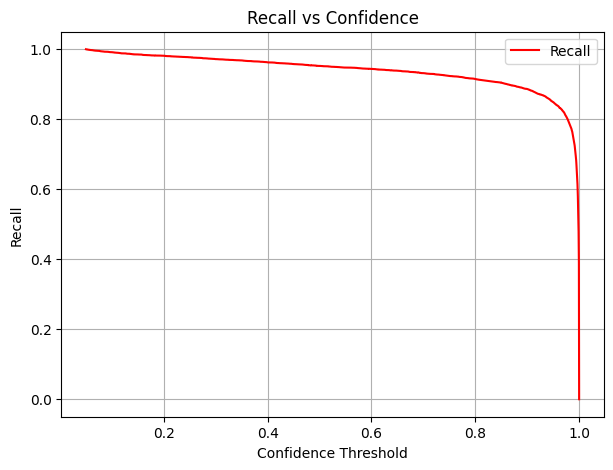

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Set your IoU threshold (commonly 0.5)
iou_threshold = 0.5

# Flatten predictions and GTs
scores = []
labels = []
pred_classes = []
gt_classes = []

# Matching function
def compute_iou(boxA, boxB):
    # intersection
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)
    if interArea == 0:
        return 0.0

    # union
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

# Collect predictions vs GT for all classes (or specific class if desired)
for pred, gt in zip(all_predictions, ground_truths):
    pred_boxes = pred['boxes']
    pred_labels = pred['labels']
    pred_scores = pred['scores']
    
    gt_boxes = gt['boxes']
    gt_labels = gt['labels']

    matched_gt = set()
    
    for p_idx in range(len(pred_boxes)):
        best_iou = 0
        best_gt_idx = -1
        for g_idx in range(len(gt_boxes)):
            if g_idx in matched_gt:
                continue
            iou = compute_iou(pred_boxes[p_idx], gt_boxes[g_idx])
            if iou > best_iou:
                best_iou = iou
                best_gt_idx = g_idx

        is_tp = 0
        if best_iou >= iou_threshold and pred_labels[p_idx] == gt_labels[best_gt_idx]:
            is_tp = 1
            matched_gt.add(best_gt_idx)

        scores.append(pred_scores[p_idx].item())
        labels.append(is_tp)

# Convert to NumPy
scores = np.array(scores)
labels = np.array(labels)

# Compute Precision-Recall
precision, recall, thresholds = precision_recall_curve(labels, scores)

# F1 computation
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)

# Plot Precision-Recall Curve
plt.figure(figsize=(7, 5))
plt.plot(recall, precision, label="PR Curve", color="blue")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.legend()
plt.show()

# Plot F1 vs Confidence Threshold
plt.figure(figsize=(7, 5))
plt.plot(thresholds, f1_scores[:-1], label="F1 Score", color="green")
plt.xlabel("Confidence Threshold")
plt.ylabel("F1 Score")
plt.title("F1 vs Confidence")
plt.grid(True)
plt.legend()
plt.show()

# Plot Precision vs Confidence
plt.figure(figsize=(7, 5))
plt.plot(thresholds, precision[:-1], label="Precision", color="purple")
plt.xlabel("Confidence Threshold")
plt.ylabel("Precision")
plt.title("Precision vs Confidence")
plt.grid(True)
plt.legend()
plt.show()

# Plot Recall vs Confidence
plt.figure(figsize=(7, 5))
plt.plot(thresholds, recall[:-1], label="Recall", color="red")
plt.xlabel("Confidence Threshold")
plt.ylabel("Recall")
plt.title("Recall vs Confidence")
plt.grid(True)
plt.legend()
plt.show()


In [61]:
class_names = ['Car', 'Van', 'Truck', 'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram']
num_classes = len(class_names)


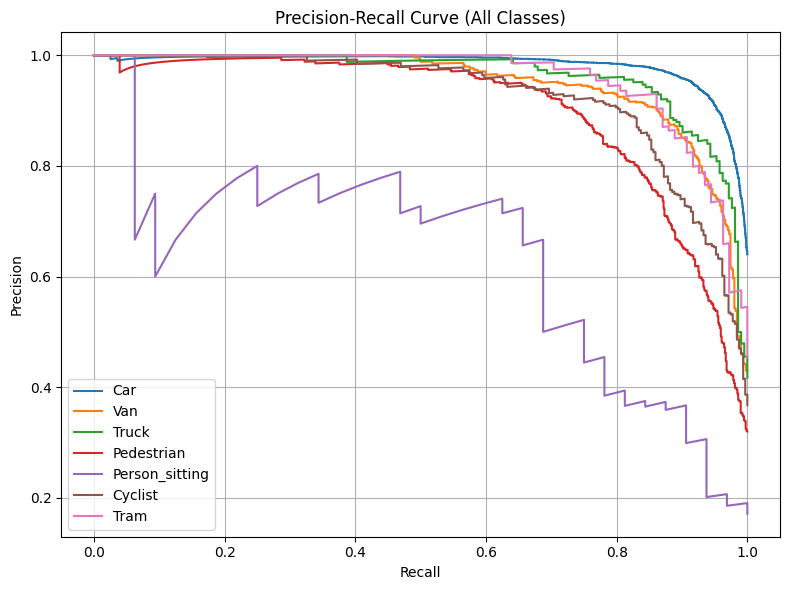

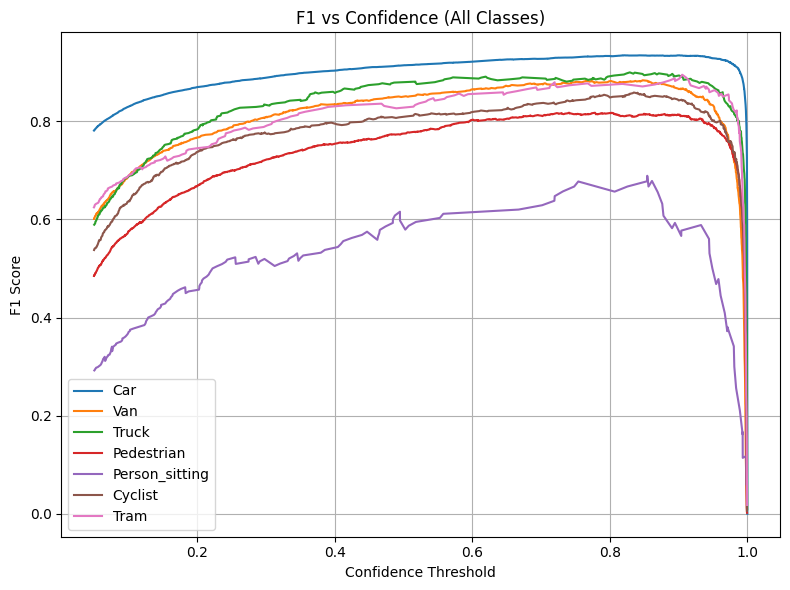

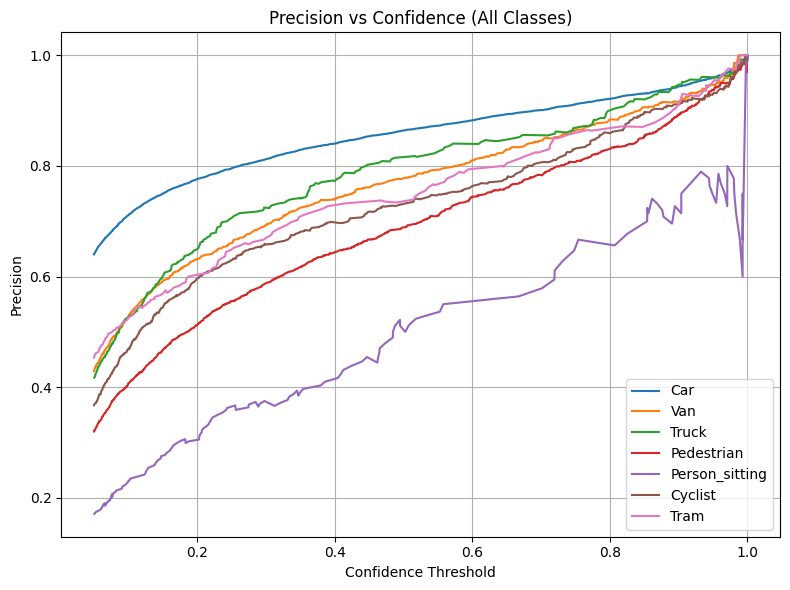

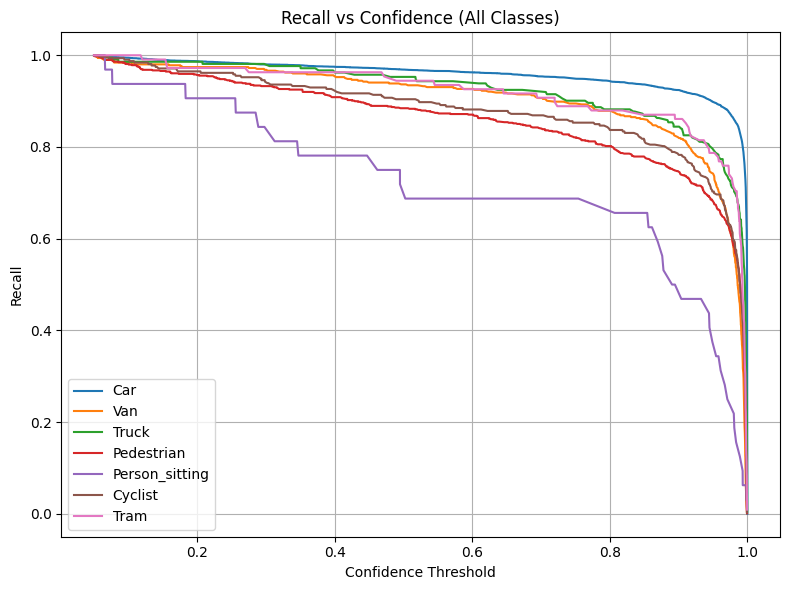

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Helper function
def compute_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    inter = max(0, xB - xA) * max(0, yB - yA)
    if inter == 0:
        return 0.0
    union = ((boxA[2] - boxA[0]) * (boxA[3] - boxA[1])) + ((boxB[2] - boxB[0]) * (boxB[3] - boxB[1])) - inter
    return inter / union

# IoU threshold
iou_thresh = 0.5

# Store curves
pr_curves = {}
f1_curves = {}
precision_conf = {}
recall_conf = {}
thresholds_all = {}

for class_id, class_name in enumerate(class_names, start=1):  # classes are 1-indexed
    y_true = []
    y_scores = []

    for preds, gts in zip(all_predictions, ground_truths):
        pred_boxes = preds['boxes']
        pred_labels = preds['labels']
        pred_scores = preds['scores']
        gt_boxes = gts['boxes']
        gt_labels = gts['labels']

        matched_gt = set()

        for pb, pl, ps in zip(pred_boxes, pred_labels, pred_scores):
            if pl != class_id:
                continue
            found_match = False
            for i, (gb, gl) in enumerate(zip(gt_boxes, gt_labels)):
                if i in matched_gt:
                    continue
                if gl != class_id:
                    continue
                iou = compute_iou(pb.tolist(), gb.tolist())
                if iou >= iou_thresh:
                    found_match = True
                    matched_gt.add(i)
                    break
            y_true.append(1 if found_match else 0)
            y_scores.append(ps.item())

    if len(y_true) == 0:
        continue

    # Precision-recall
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-6)

    pr_curves[class_name] = (recall, precision)
    f1_curves[class_name] = (thresholds, f1[:-1])  # len(thresholds) == len(f1) - 1
    precision_conf[class_name] = (thresholds, precision[:-1])
    recall_conf[class_name] = (thresholds, recall[:-1])
    thresholds_all[class_name] = thresholds

# ===== PLOTTING ===== #

# 1. Precision-Recall curve (All classes)
plt.figure(figsize=(8, 6))
for cls in pr_curves:
    recall, precision = pr_curves[cls]
    plt.plot(recall, precision, label=cls)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (All Classes)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# 2. F1 vs Confidence
plt.figure(figsize=(8, 6))
for cls in f1_curves:
    thresholds, f1 = f1_curves[cls]
    plt.plot(thresholds, f1, label=cls)
plt.xlabel("Confidence Threshold")
plt.ylabel("F1 Score")
plt.title("F1 vs Confidence (All Classes)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# 3. Precision vs Confidence
plt.figure(figsize=(8, 6))
for cls in precision_conf:
    thresholds, prec = precision_conf[cls]
    plt.plot(thresholds, prec, label=cls)
plt.xlabel("Confidence Threshold")
plt.ylabel("Precision")
plt.title("Precision vs Confidence (All Classes)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# 4. Recall vs Confidence
plt.figure(figsize=(8, 6))
for cls in recall_conf:
    thresholds, rec = recall_conf[cls]
    plt.plot(thresholds, rec, label=cls)
plt.xlabel("Confidence Threshold")
plt.ylabel("Recall")
plt.title("Recall vs Confidence (All Classes)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [63]:
import os
import csv

# Output directory
output_dir = "curve_csvs"
os.makedirs(output_dir, exist_ok=True)

# Save F1 vs Confidence
for cls in f1_curves:
    thresholds, f1 = f1_curves[cls]
    with open(os.path.join(output_dir, f"{cls}_f1_conf.csv"), "w", newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["Confidence", "F1"])
        for t, v in zip(thresholds, f1):
            writer.writerow([round(t, 6), round(v, 6)])

# Save Precision vs Confidence
for cls in precision_conf:
    thresholds, prec = precision_conf[cls]
    with open(os.path.join(output_dir, f"{cls}_precision_conf.csv"), "w", newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["Confidence", "Precision"])
        for t, v in zip(thresholds, prec):
            writer.writerow([round(t, 6), round(v, 6)])

# Save Recall vs Confidence
for cls in recall_conf:
    thresholds, rec = recall_conf[cls]
    with open(os.path.join(output_dir, f"{cls}_recall_conf.csv"), "w", newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["Confidence", "Recall"])
        for t, v in zip(thresholds, rec):
            writer.writerow([round(t, 6), round(v, 6)])

# Save Precision-Recall curve
for cls in pr_curves:
    recall, precision = pr_curves[cls]
    with open(os.path.join(output_dir, f"{cls}_pr_curve.csv"), "w", newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["Recall", "Precision"])
        for r, p in zip(recall, precision):
            writer.writerow([round(r, 6), round(p, 6)])


In [65]:
!pip install seaborn


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 6.5 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip


In [67]:
kitti_classes = [
    '__background__',  # index 0
    'Car', 'Van', 'Truck', 'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram'
]


In [68]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()

true_labels = []
pred_labels = []

CONFIDENCE_THRESHOLD = 0.5  # use what you had during metric computation

with torch.no_grad():
    for images, targets in data_loader_test:
        images = [img.to(device) for img in images]
        outputs = model(images)

        for output, target in zip(outputs, targets):
            gt_labels = target['labels'].cpu().numpy()
            pred_scores = output['scores'].cpu().numpy()
            pred_classes = output['labels'].cpu().numpy()

            # Filter predictions by confidence threshold
            valid_indices = np.where(pred_scores > CONFIDENCE_THRESHOLD)[0]
            pred_classes = pred_classes[valid_indices]

            # Append all labels
            true_labels.extend(gt_labels)
            pred_labels.extend(pred_classes)


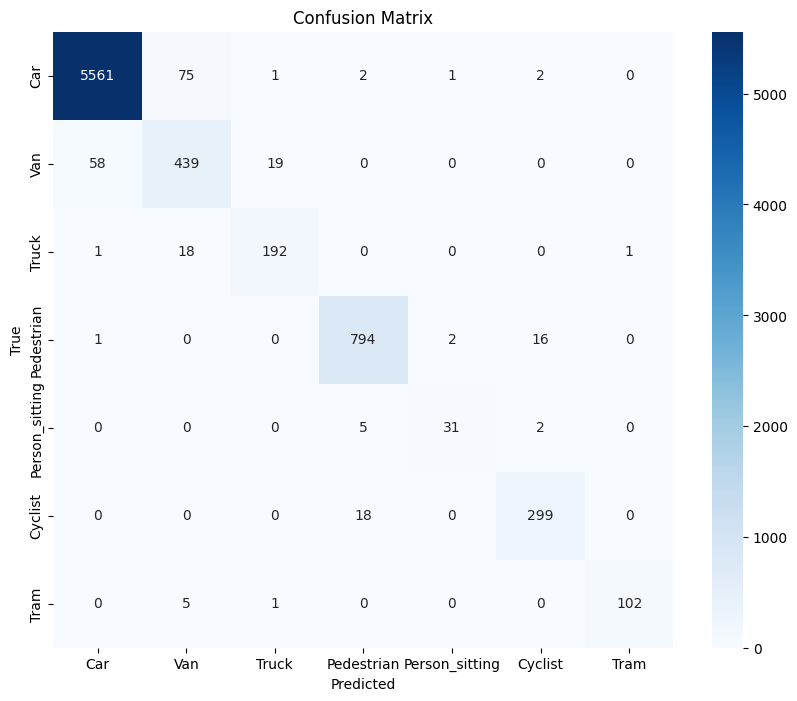

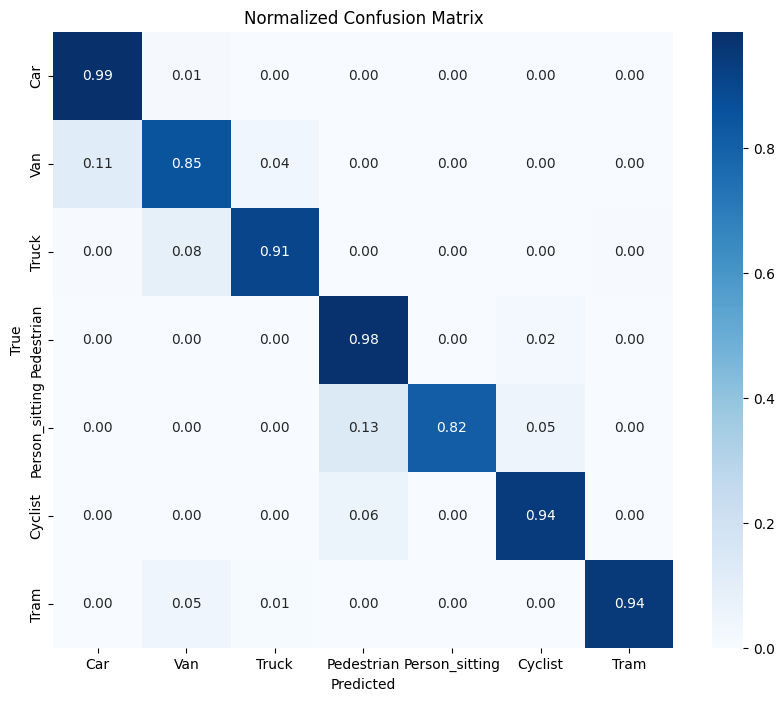

In [71]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Make sure this matches the classes used in training
kitti_classes = ['Car', 'Van', 'Truck', 'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram']

num_classes = len(kitti_classes)
true_labels = []
pred_labels = []

model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with torch.no_grad():
    for images, targets in data_loader_test:
        images = list(img.to(device) for img in images)
        outputs = model(images)
        
        for i, output in enumerate(outputs):
            gt_boxes = targets[i]['boxes'].to(device)
            gt_labels = targets[i]['labels'].to(device)
            pred_boxes = output['boxes']
            pred_scores = output['scores']
            pred_labels_out = output['labels']

            if len(pred_boxes) == 0:
                continue

            # Match predictions to ground truths using IoU
            ious = torchvision.ops.box_iou(gt_boxes, pred_boxes)
            matched_pred_idxs = ious.argmax(dim=1)
            matched_ious = ious.max(dim=1).values

            for gt_idx, iou in enumerate(matched_ious):
                if iou >= 0.5:
                    true_class = gt_labels[gt_idx].item() - 1  # shift by 1 (background excluded)
                    pred_class = pred_labels_out[matched_pred_idxs[gt_idx]].item() - 1
                    if 0 <= true_class < num_classes and 0 <= pred_class < num_classes:
                        true_labels.append(true_class)
                        pred_labels.append(pred_class)

# ✅ Compute confusion matrix
cm = confusion_matrix(true_labels, pred_labels, labels=list(range(num_classes)))
cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)

# ✅ Plot raw confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=kitti_classes, yticklabels=kitti_classes, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ✅ Plot normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', xticklabels=kitti_classes, yticklabels=kitti_classes, cmap='Blues')
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [73]:
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn

# Use num_classes = 8 (excluding background; includes only KITTI classes)
model = fasterrcnn_resnet50_fpn(pretrained=False, num_classes=8)

# Load trained weights
model.load_state_dict(torch.load("fasterrcnn_kitti_epoch80.pth"))
model.eval()


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [74]:
# Trace or Script it
scripted_model = torch.jit.script(model)

# Optimize and export
from torch.utils.mobile_optimizer import optimize_for_mobile
optimized_model = optimize_for_mobile(scripted_model)
optimized_model._save_for_lite_interpreter("fasterrcnn_mobile.ptl")


RuntimeError: __torch__ types other than custom c++ classes (__torch__.torch.classes)are not supported in lite interpreter. Workaround: instead of using arbitrary class type (class Foo()), define a pytorch class (class Foo(torch.nn.Module)). The problematic type is: __torch__.torchvision.models.detection.image_list.ImageList

In [76]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn

# Set class count and load trained weights
num_classes = 9  # 8 + background
model = fasterrcnn_resnet50_fpn(num_classes=num_classes)
checkpoint = torch.load("fasterrcnn_kitti_epoch80.pth", map_location='cpu')
model.load_state_dict(checkpoint['model'])
model.eval()


KeyError: 'model'

In [77]:
plt.savefig("confusion_matrix.png", dpi=300, bbox_inches='tight')
plt.savefig("confusion_matrix_normalized.png", dpi=300, bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

In [78]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision
import cv2

# Define class labels (excluding background)
kitti_classes = ['Car', 'Van', 'Truck', 'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram']

# Load model with 9 classes (background + 8 KITTI classes)
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, num_classes=9)
model.load_state_dict(torch.load("fasterrcnn_kitti_epoch80.pth"))
model.eval().cuda()

# Load and preprocess image
image_path = '11.jpg'  # your test image
image = Image.open(image_path).convert("RGB")
transform = transforms.ToTensor()
img_tensor = transform(image).cuda()

# Run inference
with torch.no_grad():
    prediction = model([img_tensor])[0]

# Convert tensor to CPU for visualization
img_np = img_tensor.permute(1, 2, 0).cpu().numpy()
img_np = (img_np * 255).astype('uint8')

# Plot results
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.imshow(img_np)

for box, label, score in zip(prediction['boxes'], prediction['labels'], prediction['scores']):
    if score > 0.5:
        xmin, ymin, xmax, ymax = box
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        class_name = kitti_classes[label - 1]  # Subtract 1 to skip background
        ax.text(xmin, ymin - 5, f'{class_name}: {score:.2f}', color='yellow', fontsize=12, backgroundcolor='black')

plt.axis('off')
plt.tight_layout()
plt.show()


RuntimeError: Error(s) in loading state_dict for FasterRCNN:
	size mismatch for roi_heads.box_predictor.cls_score.weight: copying a param with shape torch.Size([8, 1024]) from checkpoint, the shape in current model is torch.Size([9, 1024]).
	size mismatch for roi_heads.box_predictor.cls_score.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([9]).
	size mismatch for roi_heads.box_predictor.bbox_pred.weight: copying a param with shape torch.Size([32, 1024]) from checkpoint, the shape in current model is torch.Size([36, 1024]).
	size mismatch for roi_heads.box_predictor.bbox_pred.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([36]).

In [80]:
plt.savefig("Recall vs Confidence (All Classes).png", dpi=300, bbox_inches='tight')
plt.savefig("Precision-Recall Curve (All Classes).png", dpi=300, bbox_inches='tight')
plt.savefig("F1 vs Confidence (All Classes).png", dpi=300, bbox_inches='tight')
plt.savefig("Recall vs Confidence (All Classes).png", dpi=300, bbox_inches='tight')


<Figure size 640x480 with 0 Axes>

In [81]:
import torch
import torchvision
import PIL
import matplotlib
import numpy
import pandas
import cv2
import sklearn

# Optional: Add any additional libraries you used
try:
    import seaborn
except ImportError:
    seaborn = None

# Save to a file
with open("library_versions.txt", "w") as f:
    f.write(f"torch=={torch.__version__}\n")
    f.write(f"torchvision=={torchvision.__version__}\n")
    f.write(f"CUDA available: {torch.cuda.is_available()} ({torch.version.cuda})\n")
    f.write(f"Pillow=={PIL.__version__}\n")
    f.write(f"matplotlib=={matplotlib.__version__}\n")
    f.write(f"numpy=={numpy.__version__}\n")
    f.write(f"pandas=={pandas.__version__}\n")
    f.write(f"opencv-python=={cv2.__version__}\n")
    f.write(f"scikit-learn=={sklearn.__version__}\n")
    if seaborn:
        f.write(f"seaborn=={seaborn.__version__}\n")
    else:
        f.write("seaborn==Not Installed\n")

print("Library versions saved to 'library_versions.txt'")


Library versions saved to 'library_versions.txt'


In [86]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision.transforms as T
from PIL import Image, ImageDraw, ImageFont
import os

# KITTI classes excluding 'Misc' and 'DontCare'
kitti_classes = [
    '__background__',
    'Car', 'Van', 'Truck', 'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram'
]

# Load the model with 8 classes + background = 9
def get_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=None)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

# Load model
model_path = "fasterrcnn_kitti_epoch80.pth"
model = get_model(num_classes=8)
model.load_state_dict(torch.load(model_path))
model.eval().cuda()

# Image transform
transform = T.Compose([
    T.ToTensor()
])

# Inference function
def run_inference_on_images(image_folder, output_folder, threshold=0.5):
    os.makedirs(output_folder, exist_ok=True)
    image_paths = [os.path.join(image_folder, fname) for fname in os.listdir(image_folder) if fname.lower().endswith(('.jpg', '.png'))]

    font = ImageFont.load_default()

    for img_path in image_paths:
        image = Image.open(img_path).convert("RGB")
        img_tensor = transform(image).cuda()
        with torch.no_grad():
            output = model([img_tensor])[0]

        draw = ImageDraw.Draw(image)
        for box, label, score in zip(output['boxes'], output['labels'], output['scores']):
            if score >= threshold:
                box = box.cpu().numpy()
                label_text = kitti_classes[label]
                score_text = f"{score:.2f}"
                draw.rectangle(box.tolist(), outline='red', width=3)
                draw.text((box[0], box[1]), f"{label_text} {score_text}", fill='yellow', font=font)

        out_path = os.path.join(output_folder, os.path.basename(img_path))
        image.save(out_path)
        print(f"Saved: {out_path}")

# Example usage
run_inference_on_images(
    image_folder="sample_images",         # Input folder with test images
    output_folder="detections_output",    # Output folder to save detections
    threshold=0.5                         # Confidence threshold
)


Saved: detections_output/10.jpg
Saved: detections_output/15.jpg
Saved: detections_output/14.jpg
Saved: detections_output/12.jpg
Saved: detections_output/13.jpg
Saved: detections_output/11.jpg


In [87]:
kitti_classes = ['Car', 'Van', 'Truck', 'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram']


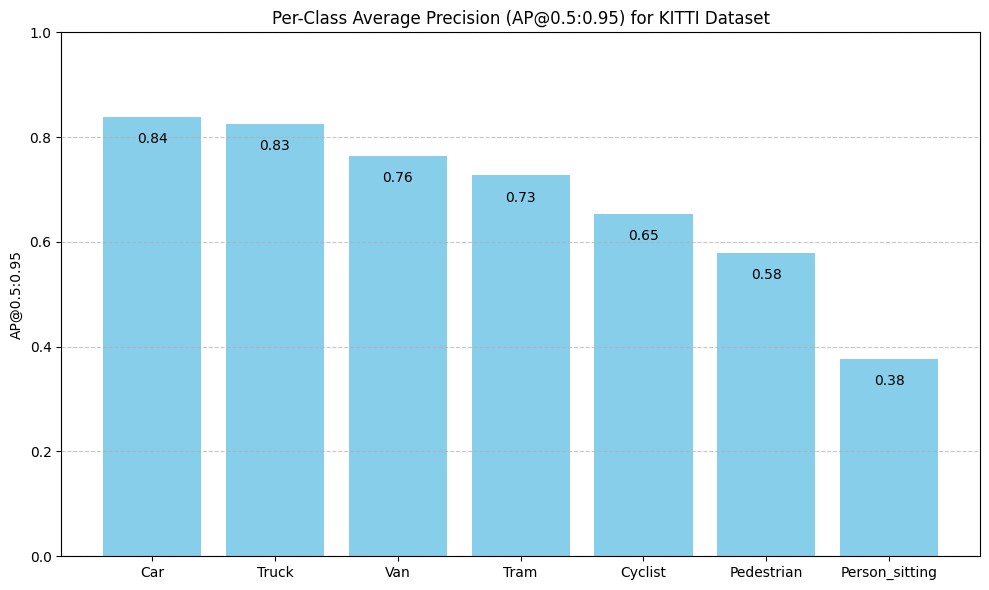

In [90]:
import matplotlib.pyplot as plt

# Example AP values (replace with your actual values)
# Use actual values from your metric computation script
ap_5_95_per_class = {
    'Car': 0.8384,
    'Van': 0.7645,
    'Truck': 0.8258,
    'Pedestrian': 0.5787,
    'Person_sitting': 0.3765,
    'Cyclist': 0.6529,
    'Tram': 0.7268
}

# Sort classes by AP (optional)
ap_5_95_per_class = dict(sorted(ap_5_95_per_class.items(), key=lambda x: x[1], reverse=True))

classes = list(ap_5_95_per_class.keys())
ap_values = list(ap_5_95_per_class.values())

plt.figure(figsize=(10, 6))
bars = plt.bar(classes, ap_values, color='skyblue')
plt.ylim(0, 1.0)
plt.ylabel('AP@0.5:0.95')
plt.title('Per-Class Average Precision (AP@0.5:0.95) for KITTI Dataset')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height - 0.05, f"{height:.2f}", ha='center', color='black')

plt.tight_layout()
plt.savefig("ap50_per_class.png", dpi=300)
plt.show()
